## Evaluation Metrics for Classification

Previously we trained a model for predicting churn. How do we know if it's good?

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

Let's train the model again to use its results later in this notebook

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0)

df.columns = df.columns.str.lower().str.replace(' ', '_')

string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)

y_train = df_train.churn.values
y_val = df_val.churn.values

del df_train['churn']
del df_val['churn']

In [5]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [6]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

In [7]:
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,1
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [8]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]

In [9]:
small_subset = ['contract', 'tenure', 'totalcharges']
train_dict_small = df_train[small_subset].to_dict(orient='records')
dv_small = DictVectorizer(sparse=False)
dv_small.fit(train_dict_small)

X_small_train = dv_small.transform(train_dict_small)

model_small = LogisticRegression(solver='liblinear', random_state=1)
model_small.fit(X_small_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,1
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [10]:
val_dict_small = df_val[small_subset].to_dict(orient='records')
X_small_val = dv_small.transform(val_dict_small)

y_pred_small = model_small.predict_proba(X_small_val)[:, 1]

In [11]:
y_pred = model.predict_proba(X_val)[:, 1]
churn = y_pred >= 0.5
(churn == y_val).mean()

np.float64(0.8016129032258065)

## 4.2 Accuracy and dummy model

Let's answer if 80% accuracy is good or not!

* Evaluate the model on different thresholds
* Check the accuracy of dummy baselines

In [12]:
from sklearn.metrics import accuracy_score

In [13]:
accuracy_score(y_val, y_pred >= 0.5)

0.8016129032258065

In [14]:
# Number of customers we have
len(y_val)

1860

In [15]:
# How many desicions were correct
(churn == y_val).sum()

np.int64(1491)

In [16]:
1491/1860

0.8016129032258065

Here we used 0.5 threshold, but is it good or not?

Now we can take our customers and try to move this decision threshold to 0.3 or 0.6, for example. 

In [17]:
thresholds = np.linspace(0, 1, 11)
thresholds

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [18]:
# function to check different thresholds
thresholds = np.linspace(0, 1, 21)

accuracies = []

for t in thresholds:
    acc = accuracy_score(y_val, y_pred >= t) # from sklearn.metrics
    accuracies.append(acc)
    print('%0.2f %0.3f' % (t, acc))

0.00 0.261
0.05 0.501
0.10 0.595
0.15 0.640
0.20 0.690
0.25 0.730
0.30 0.755
0.35 0.767
0.40 0.782
0.45 0.795
0.50 0.802
0.55 0.790
0.60 0.790
0.65 0.788
0.70 0.774
0.75 0.752
0.80 0.742
0.85 0.739
0.90 0.739
0.95 0.739
1.00 0.739


Here we can see that 0.5 actually the best threshold.

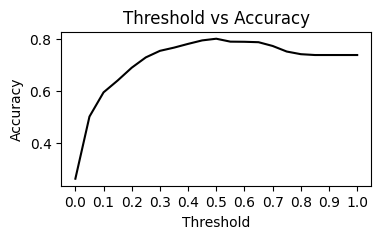

In [19]:
plt.figure(figsize=(4, 2))

plt.plot(thresholds, accuracies, color='black')

plt.title('Threshold vs Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')

plt.xticks(np.linspace(0, 1, 11))

# plt.savefig('04_threshold_accuracy.svg')

plt.show()

In [20]:
# Check values 0.0 and 1.0
y_pred >= 1.0
# All values are false

array([False, False, False, ..., False, False, False], shape=(1860,))

In [21]:
from collections import Counter

In [22]:
# How many false values are there?
Counter(y_pred >= 1.0)

Counter({np.False_: 1860})

Our model is 80% accurate

Dummy model (when threshold is 1.0 and we say nobody churn) is 74% accurate

Looks like we are getting only 6% increase in accuracy, so accuracy does not tell us how good the model is for this particular case of churning customers. The reason is that if we look at distribution of our y_val, we can see that most of the users are non churning.

In [23]:
Counter(y_val)

Counter({np.int64(0): 1374, np.int64(1): 486})

In [24]:
# Percent of non churning customers
1 - y_val.mean()

np.float64(0.7387096774193549)

Here we can see **class imbalance**, it means we have a lot more customers who are non churning, than churning one.

So accuracy is a score that for cases with class imbalance can be misleading. In such cases it is useful to use other metrics and different way of eveluation a quality of our model, that is not affected by class imbalance.

In [25]:
churn_small = y_pred_small >= 0.5
(churn_small == y_val).mean()

np.float64(0.7672043010752688)

In [26]:
accuracy_score(y_val, churn_small)

0.7672043010752688

In [27]:
size_val = len(y_val)
baseline = np.repeat(False, size_val)
baseline

array([False, False, False, ..., False, False, False], shape=(1860,))

In [28]:
accuracy_score(baseline, y_val)

0.7387096774193549

## 4.3 Confusion table

* Different types of errors and correct decisions
* Arranging them in a table

In [29]:
true_positive = ((y_pred >= 0.5) & (y_val == 1)).sum()
false_positive = ((y_pred >= 0.5) & (y_val == 0)).sum()
false_negative = ((y_pred < 0.5) & (y_val == 1)).sum()
true_negative = ((y_pred < 0.5) & (y_val == 0)).sum()

true_positive, false_positive, false_negative, true_negative

(np.int64(289), np.int64(172), np.int64(197), np.int64(1202))

In [30]:
confusion_table = np.array(
     # predict neg    pos
    [[true_negative, false_positive], # actual neg
     [false_negative, true_positive]]) # actual pos

confusion_table

array([[1202,  172],
       [ 197,  289]])

Here we can see more FN (n = 197) than FP (n = 172).
* FP - people who getting email with promotion but they are not going to churn, so we are loosing money!
* FN - we are not sending email and customers are leaving and we are loosing profit here.

In [31]:
# Calculate relative numbers (normalize)
(confusion_table / confusion_table.sum()).round(2)

array([[0.65, 0.09],
       [0.11, 0.16]])

Here in confusion table instead of just one number we can see four numbers for better understanding of what kind of correct and incorrect decisions we are making with our model.

From cinfusion matrix we can derive other metrics.

## 4.4 Precision and Recall

**Precision and Recall** are metrics that evaluate binary classification models by measuring how many predicted positives are correct (precision) and how many actual positives are successfully identified (recall).

In [32]:
accuracy = (true_positive + true_negative) / confusion_table.sum()
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
accuracy, precision, recall

(np.float64(0.8016129032258065),
 np.float64(0.6268980477223427),
 np.float64(0.5946502057613169))

What we have in our case:

* Precision 63%, means we incorrectly identified 37% of customers
* Recall 59%, and in this case 41% of customers who are churning we failed to identify them
* Accuracy 80% - at first it looks like it is pretty high number, but when we look at precision and recall we can see that our model is not very good. So in such cases accuracy is not the best metric and can be misleading.

In [33]:
confusion_table / confusion_table.sum()

array([[0.64623656, 0.09247312],
       [0.10591398, 0.15537634]])

## 4.5 ROC curves: TPR and FPR

**Receiver Operating Characteristic** or **ROC** is a curve that shows how well a binary classifier separates classes by plotting the true positive rate against the false positive rate across **all possible different thresholds**. This is a way of describing of performance of a binary classification model.

FPR means False Positive Rate — the proportion of actual negatives that the model incorrectly labels as positive. Fraction of FPs among all negative examples.

TPR means True Positive Rate — the proportion of actual positives that the model correctly identifies as positive (also called sensitivity or recall).

In [34]:
tpr = true_positive / (true_positive + false_negative)
tpr

np.float64(0.5946502057613169)

In [35]:
fpr = false_positive / (false_positive + true_negative)
fpr

np.float64(0.12518195050946143)

In [36]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds: #B
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    fn = ((y_pred < t) & (y_val == 1)).sum()
    tn = ((y_pred < t) & (y_val == 0)).sum()
    scores.append((t, tp, fp, fn, tn))

df_scores = pd.DataFrame(scores)
df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

In [37]:
df_scores[::10] # Look at every 10th row

,threshold,tp,fp,fn,tn
0,0.0,486,1374,0,0
10,0.1,458,726,28,648
20,0.2,421,512,65,862
30,0.3,380,350,106,1024
40,0.4,337,257,149,1117
50,0.5,289,172,197,1202
60,0.6,200,105,286,1269
70,0.7,99,34,387,1340
80,0.8,7,1,479,1373
90,0.9,0,0,486,1374


In [38]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [39]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,458,726,28,648,0.942387,0.528384
20,0.2,421,512,65,862,0.866255,0.372635
30,0.3,380,350,106,1024,0.781893,0.254731
40,0.4,337,257,149,1117,0.693416,0.187045
50,0.5,289,172,197,1202,0.594650,0.125182
60,0.6,200,105,286,1269,0.411523,0.076419
70,0.7,99,34,387,1340,0.203704,0.024745
80,0.8,7,1,479,1373,0.014403,0.000728
90,0.9,0,0,486,1374,0.000000,0.000000


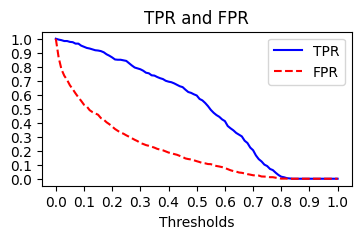

In [40]:
# Now we can plot TPR and FPR
plt.figure(figsize=(4, 2))

plt.plot(df_scores.threshold, df_scores.tpr, color='blue', linestyle='solid', label='TPR')
plt.plot(df_scores.threshold, df_scores.fpr, color='red', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Thresholds')
plt.title('TPR and FPR')

# plt.savefig('04_fpr_tpr_plot.svg')

plt.show()

TPR and FPR go down with different rate. FPR goes down faster and actually we want it to go down as fast as possible, white we want TPR to be around 1.

Now we want to compare it with something, for that we can use **random model**.

## Random baseline

In [41]:
# Let's assign every customer a random score between 0 and 1
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))
y_rand.round(3)


array([0.417, 0.72 , 0.   , ..., 0.148, 0.923, 0.044], shape=(1860,))

In [42]:
# Accuracy of random model sould be quite low
((y_rand >= 0.5) == y_val).mean()

np.float64(0.478494623655914)

Now we want to plot TPR and FPR for this random model.

In [43]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        tp = ((y_pred >= t) & (y_val == 1)).sum()
        fp = ((y_pred >= t) & (y_val == 0)).sum()
        fn = ((y_pred < t) & (y_val == 1)).sum()
        tn = ((y_pred < t) & (y_val == 0)).sum()

        scores.append((t, tp, fp, fn, tn))

    df_scores = pd.DataFrame(scores)
    df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [44]:
# Using tpr_fpr_dataframe for getting dataframe with random predictions
df_rand = tpr_fpr_dataframe(y_val, y_rand)
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,440,1236,46,138,0.905350,0.899563
20,0.2,392,1101,94,273,0.806584,0.801310
30,0.3,339,972,147,402,0.697531,0.707424
40,0.4,288,849,198,525,0.592593,0.617904
50,0.5,239,723,247,651,0.491770,0.526201
60,0.6,193,579,293,795,0.397119,0.421397
70,0.7,152,422,334,952,0.312757,0.307132
80,0.8,98,302,388,1072,0.201646,0.219796
90,0.9,57,147,429,1227,0.117284,0.106987


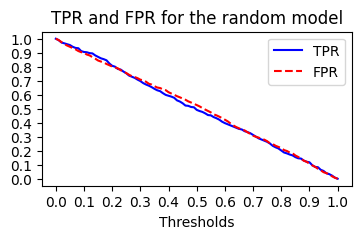

In [45]:
plt.figure(figsize=(4, 2))

plt.plot(df_rand.threshold, df_rand.tpr, color='blue', linestyle='solid', label='TPR')
plt.plot(df_rand.threshold, df_rand.fpr, color='red', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Thresholds')
plt.title('TPR and FPR for the random model')

#plt.savefig('04_fpr_tpr_plot_random.svg')

plt.show()

Now with random model it is almost a straight line!

## Ideal baseline

In this case we have a model that outputs correct predictions for everyone.

In [46]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(np.int64(1374), np.int64(486))

In [47]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_pred_ideal = np.linspace(0, 1, num_neg + num_pos)

In [48]:
1 - y_val.mean()

np.float64(0.7387096774193549)

In [49]:
#This is how the ideal model looks like.
# Above the 0.739 threshold all predictions are positive, below - negative;
# and all 100% of predictions are correct.
((y_pred_ideal >= 0.739) == y_ideal).mean()

np.float64(1.0)

In [50]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_pred_ideal)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,486,1188,0,186,1.000000,0.864629
20,0.2,486,1002,0,372,1.000000,0.729258
30,0.3,486,816,0,558,1.000000,0.593886
40,0.4,486,630,0,744,1.000000,0.458515
50,0.5,486,444,0,930,1.000000,0.323144
60,0.6,486,258,0,1116,1.000000,0.187773
70,0.7,486,72,0,1302,1.000000,0.052402
80,0.8,372,0,114,1374,0.765432,0.000000
90,0.9,186,0,300,1374,0.382716,0.000000


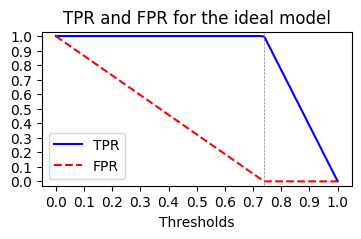

In [51]:
plt.figure(figsize=(4, 2))

plt.plot(df_ideal.threshold, df_ideal.tpr, color='blue', linestyle='solid', label='TPR')
plt.plot(df_ideal.threshold, df_ideal.fpr, color='red', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.vlines(1 - y_val.mean(), -1, 2, linewidth=0.5, linestyle='dashed', color='grey')
plt.ylim(-0.03, 1.03)

plt.xlabel('Thresholds')
plt.title('TPR and FPR for the ideal model')

# plt.savefig('04_fpr_tpr_plot_ideal.svg')

plt.show()

## Putting everything together

Now we want to plot all the models together: actual, ideal, and random models.

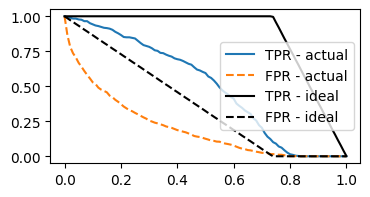

In [52]:
plt.figure(figsize=(4, 2))

plt.plot(df_scores.threshold, df_scores.tpr, linestyle='solid', label='TPR - actual')
plt.plot(df_scores.threshold, df_scores.fpr, linestyle='dashed', label='FPR - actual')

plt.plot(df_ideal.threshold, df_ideal.tpr, linestyle='solid', color='black', label='TPR - ideal')
plt.plot(df_ideal.threshold, df_ideal.fpr, linestyle='dashed', color='black', label='FPR - ideal')

#plt.plot(df_rand.threshold, df_rand.tpr, linestyle='solid', label='TPR - random')
#plt.plot(df_rand.threshold, df_rand.fpr, linestyle='dashed', label='FPR - random')

plt.legend()

## ROC curve

Now let's plot FPR vs TPR and look at ROC curve. Using such curve we can see how our model behaves at different thresholds.

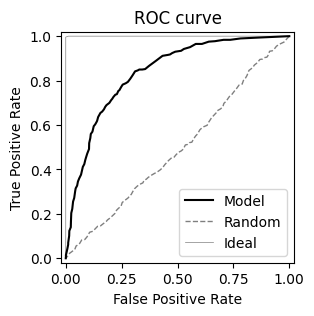

In [53]:
plt.figure(figsize=(3, 3))

plt.plot(df_scores.fpr, df_scores.tpr, color='black', label='Model')
plt.plot(df_rand.fpr, df_rand.tpr, color='black', lw=1,
         linestyle='dashed', alpha=0.5, label='Random')
plt.plot(df_ideal.fpr, df_ideal.tpr, color='black', lw=0.5,
         linestyle='solid', alpha=0.5, label='Ideal')

plt.legend()

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

# plt.savefig('04_roc_curve_with_baselines.svg')

plt.show()

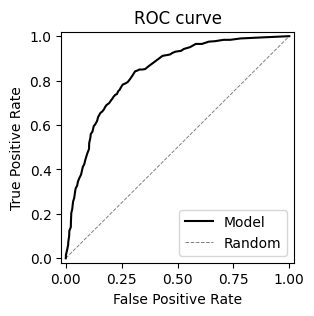

In [54]:
plt.figure(figsize=(3, 3))

plt.plot(df_scores.fpr, df_scores.tpr, color='black', label='Model')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5, label='Random')

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')
plt.legend()

# plt.savefig('04_roc_curve.svg')

plt.show()

If curve of our model below the random line, we are making a mistake and something goes wrong! Maybe we need to flip positive and negative predictions.

## Using Scikit-Learn for plotting the ROC curve

ROC curve from Scikit-Learn is **more accuarte** because it evaluates the model on more thresholds.

In [55]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [56]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

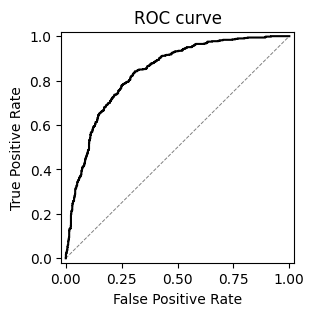

In [57]:
plt.figure(figsize=(3, 3))

plt.plot(fpr, tpr, color='black')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

plt.show()

ROC curve can be used for evaluating our model to see how our model behaves at different thresholds. And also it can be used to comparing different models. 

## 4.6 AUC: Area under the ROC curve

Building a model we want to be to ideal point as close as possible. Ideal point is a point where TPR is 1 and FPR is 0. Measuring AUC is a one way to quantify how close we are to this ideal point, so AUC can tell us how good our model is.

We can calculate AUC using Scikit-Learn. **Important:** this is not specifically for ROC curves, this is for any curve!

In [58]:
from sklearn.metrics import auc

In [59]:
df_scores_small = tpr_fpr_dataframe(y_val, y_pred_small)

In [60]:
# This is the AUC for the model where we calculated fpr and tpr manually
auc(df_scores.fpr, df_scores.tpr)

0.8359001084215382

In [61]:
# This is the AUC for data where we used sklearn to calculate fpr and tpr, this is more accurate!
auc(fpr, tpr)

0.8363366398907399

In [62]:
# AUC for the ideal model: close to 1.0
auc(df_ideal.fpr, df_ideal.tpr)

0.9999760394390833

In [63]:
auc(df_scores_small.fpr, df_scores_small.tpr)

0.8125475467380692

In [64]:
# We can use approach from previous cells to calculate AUC for a model
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8363366398907399

In [65]:
# But also we can use shortcut from sklearn
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred)

0.8363366398907399

Comparing multiple models with ROC curves

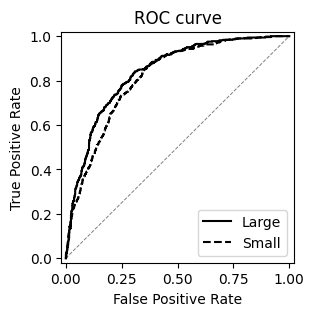

In [66]:
fpr_large, tpr_large, _ = roc_curve(y_val, y_pred)
fpr_small, tpr_small, _ = roc_curve(y_val, y_pred_small)

plt.figure(figsize=(3, 3))

plt.plot(fpr_large, tpr_large, color='black', linestyle='solid', label='Large')
plt.plot(fpr_small, tpr_small, color='black', linestyle='dashed', label='Small')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')
plt.legend(loc='lower right')

plt.show()

In [67]:
from sklearn.metrics import roc_auc_score

In [68]:
roc_auc_score(y_val, y_pred)

0.8363366398907399

In [69]:
roc_auc_score(y_val, y_pred_small)

0.8129354083179088

**Interpretation of AUC**: the probability that a randomly chosen positive example (churning customer) ranks higher than a randomly chosen negative example (non churning customer). It tells us how well our model separates positive and negative classes.

In [70]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

np.random.seed(1)
n = 100000
neg_choice = np.random.randint(low=0, high=len(neg), size=n)
pos_choice = np.random.randint(low=0, high=len(pos), size=n)
(pos[pos_choice] > neg[neg_choice]).mean()

np.float64(0.83525)

## 4.7 K-fold cross-validation

Parameter tuning - selection of the best parameter.

In [72]:
# Create a function for training a model
def train(df, y):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear')
    model.fit(X, y)

    return dv, model

# Create a function for making prediction
def predict(df, dv, model):
    cat = df[categorical + numerical].to_dict(orient='records') # convert dataframe to list of dictionaries
    
    X = dv.transform(cat) # create feature matrix using the dict vectorizer

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [74]:
y_pred = predict(df_val, dv, model) #returns numpy array with predictions

In [75]:
from sklearn.model_selection import KFold

In [77]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In case of 10 splits we take our dataframe and split it into 10 parts (each part will be 10%). So we will train a model on 90% of data and then evaluate it on 10%. And we will repeat this 10 times.

In [80]:
next(kfold.split(df_train_full))
# it consists of two arrays: train indices and validation indices

(array([   0,    1,    2, ..., 5631, 5632, 5633], shape=(5070,)),
 array([   4,   21,   28,   33,   44,   58,   67,   72,   79,   81,   82,
          98,  101,  116,  119,  125,  126,  136,  141,  147,  161,  169,
         179,  192,  196,  200,  206,  214,  222,  231,  250,  255,  259,
         276,  280,  285,  301,  308,  313,  314,  325,  343,  354,  359,
         383,  386,  407,  420,  428,  433,  440,  447,  457,  473,  486,
         496,  501,  503,  507,  545,  554,  557,  566,  574,  580,  582,
         592,  605,  608,  623,  634,  636,  645,  662,  667,  684,  687,
         689,  729,  745,  758,  763,  778,  783,  792,  795,  808,  839,
         840,  847,  850,  858,  867,  870,  871,  881,  899,  906,  927,
         929,  931,  940,  943,  976,  984,  987,  988, 1005, 1016, 1028,
        1034, 1038, 1050, 1056, 1074, 1079, 1117, 1122, 1123, 1131, 1134,
        1139, 1144, 1155, 1159, 1163, 1169, 1179, 1198, 1206, 1216, 1238,
        1247, 1256, 1272, 1297, 1298, 1310, 13

In [81]:
train_idx, val_idx = next(kfold.split(df_train_full))

In [82]:
len(train_idx), len(val_idx)

(5070, 564)

In [83]:
len(df_train_full)

5634

In [84]:
df_train_full.iloc[train_idx]

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
1814,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.70,258.35,0
5946,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,...,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.90,3160.55,1
3881,2176-osjuv,male,0,yes,no,71,yes,yes,dsl,yes,...,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.15,4681.75,0
2389,6161-erdgd,male,0,yes,yes,71,yes,yes,dsl,yes,...,yes,yes,yes,yes,one_year,no,electronic_check,85.45,6300.85,0
611,4765-oxppd,female,0,yes,yes,9,yes,no,dsl,yes,...,yes,yes,no,no,month-to-month,no,mailed_check,65.00,663.05,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2763,2250-ivbwa,male,0,yes,yes,64,yes,no,fiber_optic,yes,...,no,no,no,no,month-to-month,no,electronic_check,81.05,5135.35,0
5192,3507-gasnp,male,0,no,yes,60,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.95,1189.90,0
3980,8868-wozgu,male,0,no,no,28,yes,yes,fiber_optic,no,...,yes,no,yes,yes,month-to-month,yes,electronic_check,105.70,2979.50,1
235,1251-krreg,male,0,no,no,2,yes,yes,dsl,no,...,no,no,no,no,month-to-month,yes,mailed_check,54.40,114.10,1


In [85]:
df_train = df_train_full.iloc[train_idx]
df_val = df_train_full.iloc[val_idx]

In [ ]:
#!pip install tqdm


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [88]:
from tqdm.auto import tqdm

In [89]:
aucs = []

for train_idx, val_idx in tqdm(kfold.split(df_train_full)): # here we whapped kfold.split with tqdm to see how long each iteration takes
    df_train = df_train_full.iloc[train_idx]
    y_train = df_train.churn.values

    df_val = df_train_full.iloc[val_idx]
    y_val = df_val.churn.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    rocauc = roc_auc_score(y_val, y_pred)
    aucs.append(rocauc)

0it [00:00, ?it/s]

In [90]:
aucs

[0.8493392490816277,
 0.8413366336633662,
 0.8590269587894291,
 0.8330260883877869,
 0.8242555831265509,
 0.8416250416250417,
 0.8437154021491371,
 0.8223355471220746,
 0.8450570623981029,
 0.8611811367685119]

In [91]:
np.array(aucs).round(3)

array([0.849, 0.841, 0.859, 0.833, 0.824, 0.842, 0.844, 0.822, 0.845,
       0.861])

In [92]:
#compute mean and std of aucs
print('auc = %0.3f ± %0.3f' % (np.mean(aucs), np.std(aucs)))

auc = 0.842 ± 0.012


Tuning the parameter `C` of logistic regression. It is like regularization parameter in linear regression.

In [93]:
def train(df, y, C=1.0):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X, y)

    return dv, model

In [94]:
nfolds = 5
kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 10]):
    aucs = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))

  0%|          | 0/6 [00:00<?, ?it/s]

C=0.001, auc = 0.825 ± 0.013
C=0.01, auc = 0.839 ± 0.009
C=0.1, auc = 0.841 ± 0.008
C=0.5, auc = 0.841 ± 0.007
C=1, auc = 0.841 ± 0.007
C=10, auc = 0.841 ± 0.007


Default C=1 looks fine.

Let's now make full retraining of our final model.

In [95]:
y_train = df_train_full.churn.values
y_test = df_test.churn.values

dv, model = train(df_train_full, y_train, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
print('auc = %.3f' % auc)

auc = 0.858


**When to use cross-validation and when to use a regular hold-out validation set?**

Most of the time, a regular hold-out validation set is sufficient—especially when your dataset is large. You can simply set aside a portion of the dataset for validation.

If your dataset is smaller, or if you want to measure the standard deviation of your model’s performance and evaluate how stable it is across different subsets of the data, then you should use cross-validation.

For larger datasets, 2–3 folds are usually enough. For smaller datasets, it’s better to use more splits/folds (e.g., 5–10).